# Independent Component Analysis (ICA) implementation from scratch

This is the Python Jupyter Notebook for the Medium article about implementing the fast independent Component Analysis (ICA) algorithm.

ICA is an efficient technique to decompose linear mixtures of signals into their underlying independent components. Classical examples of where this method is used are noise reduction in images, artifact removal from time series data or identification of driving components in financial data.

Here we will start by first importing the necessary libraries and creating some toy signals which we will use to develop and test our ICA implementation.

In [1]:
import pandas as pd
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

# Enable plots inside the Jupyter NotebookLet the
%matplotlib inline

### The generative model of ICA

The ICA is based on a generative model. This means that it assumes an underlying process that generates the observed data. The ICA model is simple, it assumes that some independent source signals *s* are linear combined by a mixing matrix _A_.

$$x=As$$

### Retrieving the components

The above equations implies that if we invert *A* and multiply it with the observed signals _x_ we will retrieve our sources:

$$W=A^{-1}$$

$$s=xW$$

This means that what our ICA algorithm needs to estimate is *W*. 

### Create toy signals

We will start by creating some independent signals that will be mixed by matrix A. The independent sources signals are **(1)** a sine wave, **(2)** a saw tooth signal and **(3)** a random noise vector. After calculating their dot product with _A_ we get three linear combinations of these source signals.  

In [2]:
# Set a seed for the random number generator for reproducibility
np.random.seed(23)

# Number of samples
ns = np.linspace(0, 200, 1000)

# Source matrix
S = np.array([np.sin(ns * 1), 
              signal.sawtooth(ns * 1.9),
              np.random.random(len(ns))]).T

# Mixing matrix
A = np.array([[0.5, 1, 0.2], 
              [1, 0.5, 0.4], 
              [0.5, 0.8, 1]])

# Mixed signal matrix
X = S.dot(A).T

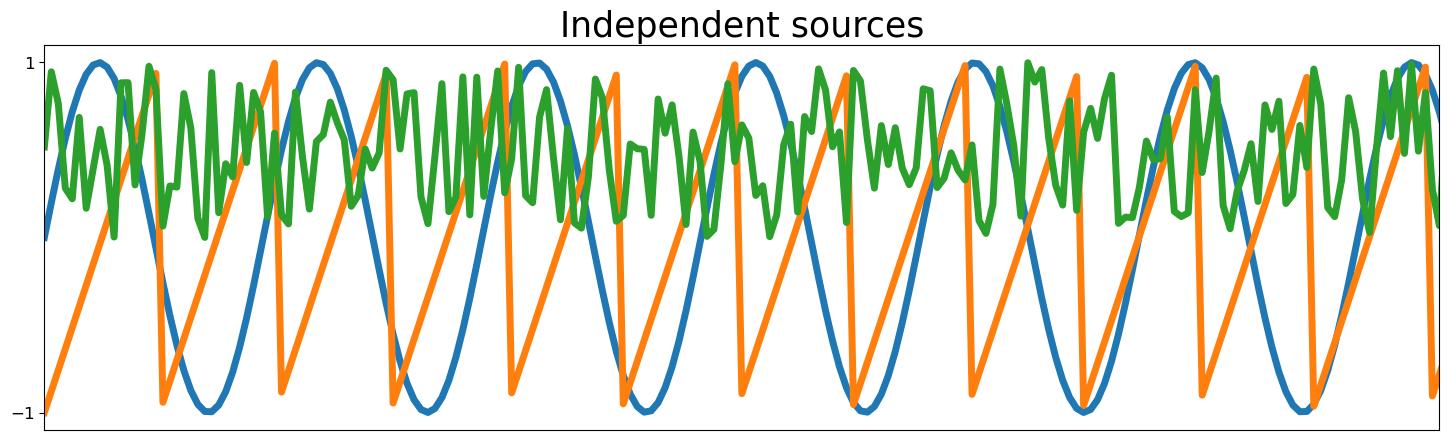

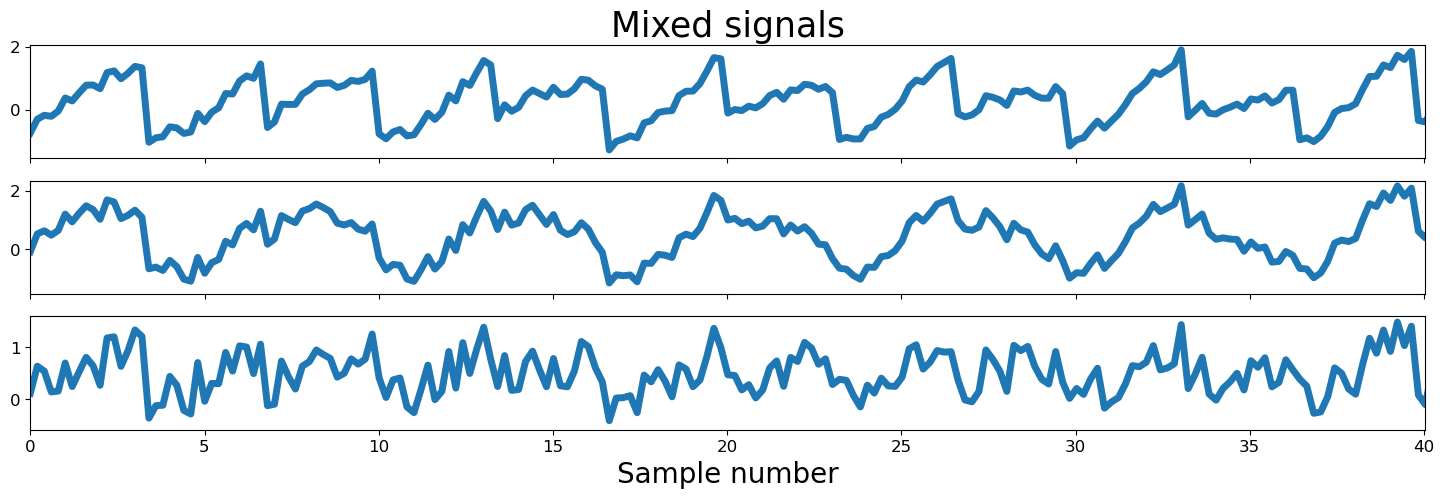

In [3]:
# Plot sources & signals
fig, ax = plt.subplots(1, 1, figsize=[18, 5])
ax.plot(ns, S, lw=5)
ax.set_xticks([])
ax.set_yticks([-1, 1])
ax.set_xlim(ns[0], ns[200])
ax.tick_params(labelsize=12)
ax.set_title('Independent sources', fontsize=25)

fig, ax = plt.subplots(3, 1, figsize=[18, 5], sharex=True)
ax[0].plot(ns, X[0], lw=5)
ax[0].set_title('Mixed signals', fontsize=25)
ax[0].tick_params(labelsize=12)

ax[1].plot(ns, X[1], lw=5)
ax[1].tick_params(labelsize=12)
ax[1].set_xlim(ns[0], ns[-1])

ax[2].plot(ns, X[2], lw=5)
ax[2].tick_params(labelsize=12)
ax[2].set_xlim(ns[0], ns[-1])
ax[2].set_xlabel('Sample number', fontsize=20)
ax[2].set_xlim(ns[0], ns[200])

plt.show()

### Interlude: Comparison of Gaussian vs. Non-Gaussian signals

In the above it was already mentioned but for the ICA to work the observed signals x need to be a **linear** combination of **independent** components. The linearity follows from the generative model, which is linear. Independence means that signal x1 does not contain any information about signal x2. From this it follows that both signals are not correlated and have a covariance of 0. However just because two signals are not correlated it does not automatically mean that they are independent. 

A third precondition that needs to be met is **non-Gaussiananity** of the independent source signals. Why is that? The joint density distribution of two independent non-Gaussian signals will be uniform on a square. Mixing these two signals with an orthogonal matrix will result in two signals that are now not independent anymore and have a uniform distribution on a parallelogram. Which means that if we are at the minimum or maximum value of one of our mixed signals we know the value of the other signal. Therefore they are not independent anymore. 
Doing the same with two Gaussian signals will result in something else. The joint distribution of the source signals is completely symmetric and so is the joint distribution of the mixed signals. Therefore it does not contain any information about the mixing matrix, the inverse of which we want to calculate. It follows that in this case the ICA algorithm will fail.

The code below illustrates these differences between Gaussian and non-Gaussian signals.

In [4]:
# Define two non-gaussian uniform components
s1 = np.random.rand(1000)
s2 = np.random.rand(1000)
s = np.array(([s1, s2]))

# Define two gaussian components
s1n = np.random.normal(size=1000)
s2n = np.random.normal(size=1000)
sn = np.array(([s1n, s2n]))

# Define orthogonal mixing matrix
A = np.array(([0.96, -0.28],[0.28, 0.96]))

# Mix signals
mixedSignals = s.T.dot(A)
mixedSignalsN = sn.T.dot(A)

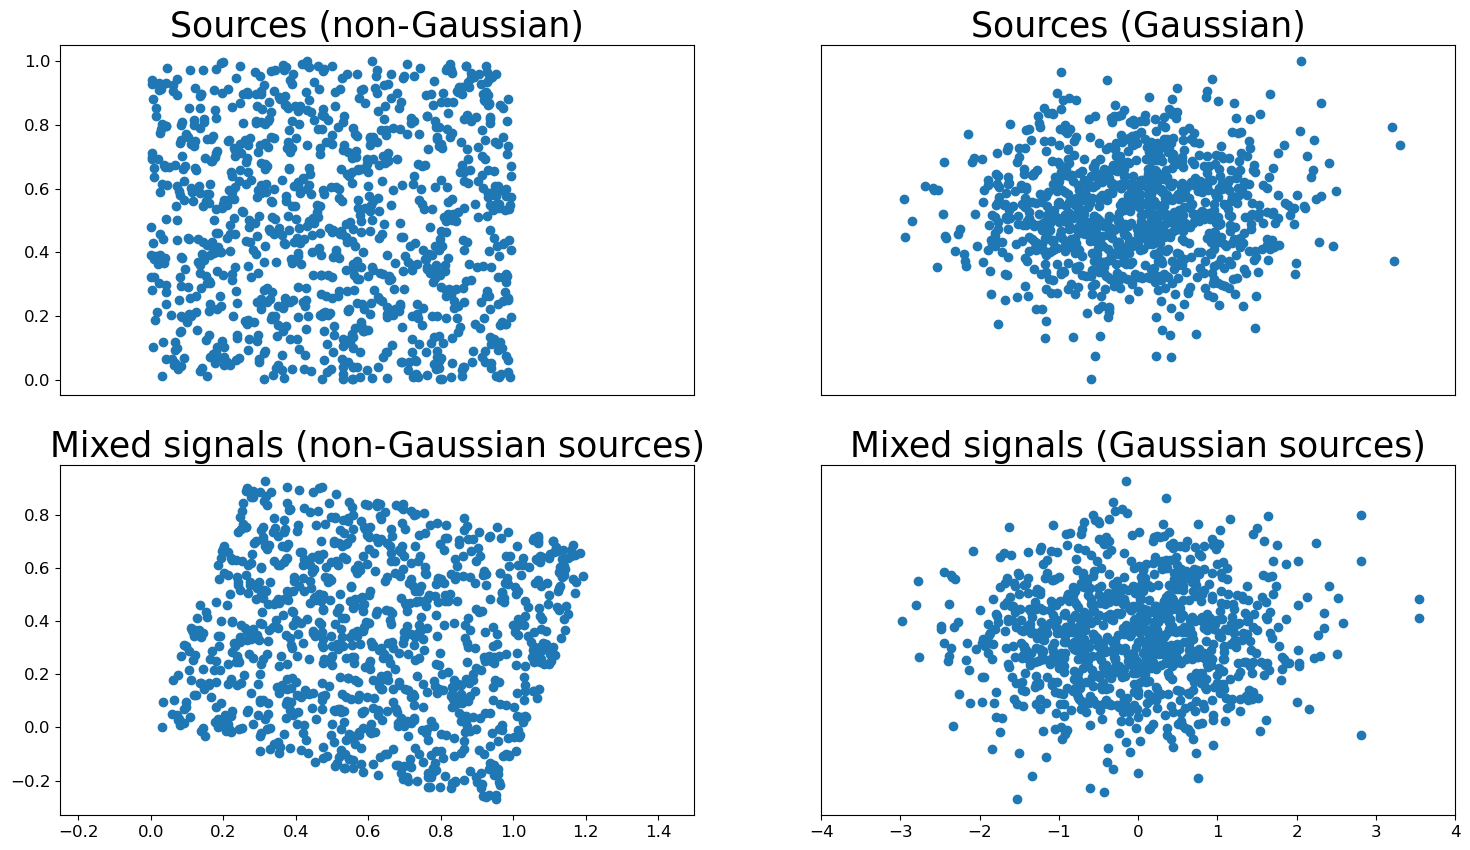

In [5]:
# Plot results
fig, ax = plt.subplots(2, 2, figsize=[18, 10])
ax[0][0].scatter(s[0], s[1])
ax[0][0].tick_params(labelsize=12)
ax[0][0].set_title('Sources (non-Gaussian)', fontsize=25)
ax[0][0].set_xlim([-0.25, 1.5])
ax[0][0].set_xticks([])

ax[0][1].scatter(sn[0], sn[1])
ax[0][1].tick_params(labelsize=12)
ax[0][1].set_title('Sources (Gaussian)', fontsize=25)
ax[0][1].set_xlim([-4, 4])
ax[0][1].set_xticks([])
ax[0][1].set_yticks([])

ax[1][0].scatter(mixedSignals.T[0], mixedSignals.T[1])
ax[1][0].tick_params(labelsize=12)
ax[1][0].set_title('Mixed signals (non-Gaussian sources)', fontsize=25)
ax[1][0].set_xlim([-0.25, 1.5])

ax[1][1].scatter(mixedSignalsN.T[0], mixedSignalsN.T[1])
ax[1][1].tick_params(labelsize=12)
ax[1][1].set_title('Mixed signals (Gaussian sources)', fontsize=25)
ax[1][1].set_xlim([-4, 4])
ax[1][1].set_yticks([])

plt.show()

### Visualize properties of toy signals

To check if the properties discussed above also apply for our toy signals we will plot them accordingly.
As expected the source signals are distributed on a square for non-Gaussian random variables. Likewise the mixed signals form a parallelogram in the right plot of Figure 3 which shows that the mixed signals are not independent anymore.

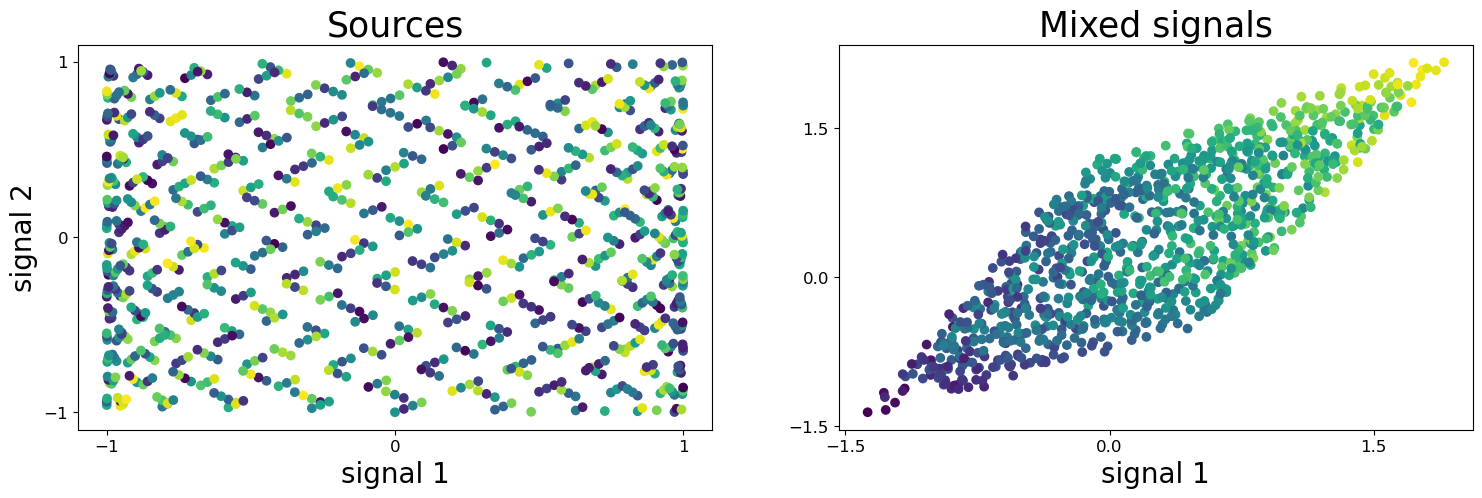

In [6]:
fig, ax = plt.subplots(1, 2, figsize=[18, 5])
ax[0].scatter(S.T[0], S.T[1], c=S.T[2])
ax[0].tick_params(labelsize=12)
ax[0].set_yticks([-1, 0, 1])
ax[0].set_xticks([-1, 0, 1])
ax[0].set_xlabel('signal 1', fontsize=20)
ax[0].set_ylabel('signal 2', fontsize=20)
ax[0].set_title('Sources', fontsize=25)

ax[1].scatter(X[0], X[1], c=X[2])
ax[1].tick_params(labelsize=12)
ax[1].set_yticks([-1.5, 0, 1.5])
ax[1].set_xticks([-1.5, 0, 1.5])
ax[1].set_xlabel('signal 1', fontsize=20)
ax[1].set_title('Mixed signals', fontsize=25)
plt.show()

## Preprocessing functions

To get an optimal estimate of the independent components it is advisable to do some pre-processing of the data. In the following the two most important pre-processing techniques are explained in more detail.

The first pre-processing step we will discuss here is **centering**. This is a simple subtraction of the mean from our input X. As a result the centered mixed signals will have zero mean which implies that also our source signals s are of zero mean. This simplifies the ICA calculation and the mean can later be added back.

In [7]:
def center(x):
    mean = np.mean(x, axis=1, keepdims=True)
    centered =  x - mean 
    return centered, mean

For the second pre-processing technique we need to calculate the covariance. So lets quickly define it.

In [8]:
def covariance(x):
    mean = np.mean(x, axis=1, keepdims=True)
    n = np.shape(x)[1] - 1
    m = x - mean

    return (m.dot(m.T))/n

The second pre-processing method is called **whitening**. The goal here is to linearly transform the observed signals X in a way that potential correlations between the signals are removed and their variances equal unity. As a result the covariance matrix of the whitened signals will be equal to the identity matrix

In [9]:
def whiten(x):
    # Calculate the covariance matrix
    coVarM = covariance(X) 
    
    # Single value decoposition
    U, S, V = np.linalg.svd(coVarM)
    
    # Calculate diagonal matrix of eigenvalues
    d = np.diag(1.0 / np.sqrt(S)) 
    
    # Calculate whitening matrix
    whiteM = np.dot(U, np.dot(d, U.T))
    
    # Project onto whitening matrix
    Xw = np.dot(whiteM, X) 
    
    return Xw, whiteM

## Implement the fast ICA algorithm

Now it is time to look at the actual ICA algorithm. As discussed above one precondition for the ICA algorithm to work is that the source signals are non-Gaussian. Therefore the result of the ICA should return sources that are as non-Gaussian as possible. To achieve this we need a measure of Gaussianity. One way is Kurtosis and it could be used here but another way has proven more efficient. Nevertheless we will have a look at kurtosis at the end of this notebook. 
For the actual algorithm however we will use the equations $g$ and $g'$ which are derivatives of $f(u)$ as defined below.

$$f(u)=\log \cosh(u)$$

$$g(u)=\tanh(u)$$

$$g'(u)=1-\tanh^{2}(u)$$

These equations allow an approximation of negentropy and will be used in the below ICA algorithm which is [based on a fixed-point iteration scheme](https://homepage.math.uiowa.edu/~whan/072.d/S3-4.pdf):

So according to the above what we have to do is to take a random guess for the weights of each component. The dot product of the random weights and the mixed signals is passed into the two functions g and g'. We then subtract the result of g' from g and calculate the mean. The result is our new weights vector. Next we could directly divide the new weights vector by its norm and repeat the above until the weights do not change anymore. There would be nothing wrong with that. However the problem we are facing here is that in the iteration for the second component we might identify the same component as in the first iteration. To solve this problem we have to decorrelate the new weights from the previously identified weights. This is what is happening in the step between updating the weights and dividing by their norm.

In [10]:
def fastIca(signals,  alpha = 1, thresh=1e-8, iterations=5000):
    m, n = signals.shape

    # Initialize random weights
    W = np.random.rand(m, m)

    for c in range(m):
            w = W[c, :].copy().reshape(m, 1)
            w = w / np.sqrt((w ** 2).sum())

            i = 0
            lim = 100
            while ((lim > thresh) & (i < iterations)):

                # Dot product of weight and signal
                ws = np.dot(w.T, signals)

                # Pass w*s into contrast function g
                wg = np.tanh(ws * alpha).T

                # Pass w*s into g prime 
                wg_ = (1 - np.square(np.tanh(ws))) * alpha

                # Update weights
                wNew = (signals * wg.T).mean(axis=1) - wg_.mean() * w.squeeze()

                # Decorrelate weights              
                wNew = wNew - np.dot(np.dot(wNew, W[:c].T), W[:c])
                wNew = wNew / np.sqrt((wNew ** 2).sum())

                # Calculate limit condition
                lim = np.abs(np.abs((wNew * w).sum()) - 1)
                
                # Update weights
                w = wNew
                
                # Update counter
                i += 1

            W[c, :] = w.T
    return W

### Pre-processing

So... before we run the ICA we need to do the pre-processing.

In [11]:
# Center signals
Xc, meanX = center(X)

# Whiten mixed signals
Xw, whiteM = whiten(Xc)

### Check whitening

Above we mentioned that the covariance matrix of the whitened signal should equal the identity matrix:

$$ covariance(\check{X})=I $$

...and as we can see below this is correct.

In [12]:
# Check if covariance of whitened matrix equals identity matrix
print(np.round(covariance(Xw)))

[[ 1. -0.  0.]
 [-0.  1.  0.]
 [ 0.  0.  1.]]


### Running the ICA

Finally... it is time to feed the whitened signals into the ICA algorithm.

In [13]:
W = fastIca(Xw,  alpha=1)

#Un-mix signals using 
unMixed = Xw.T.dot(W.T)

# Subtract mean
unMixed = (unMixed.T - meanX).T

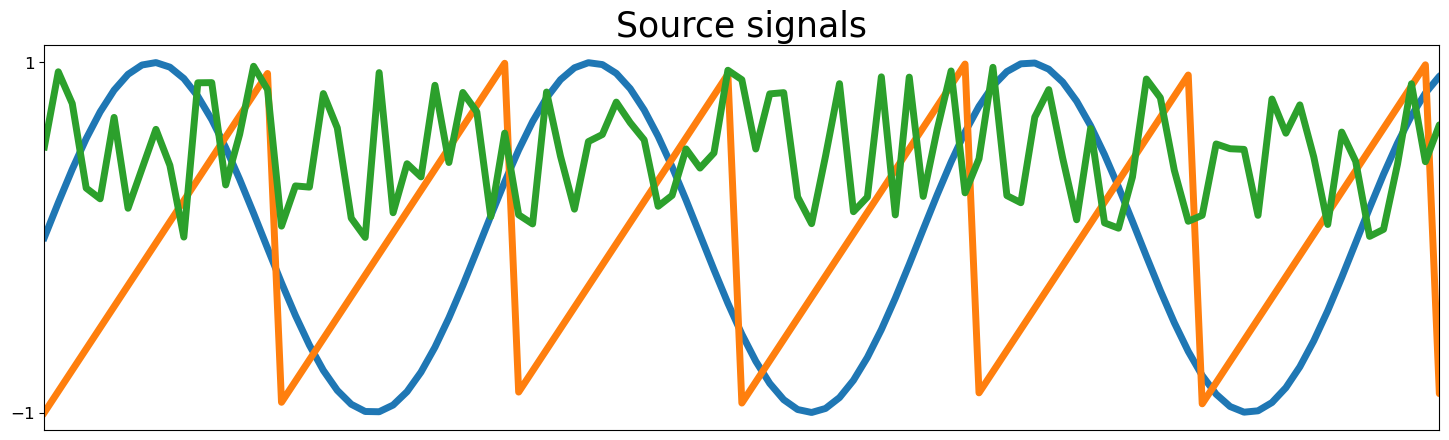

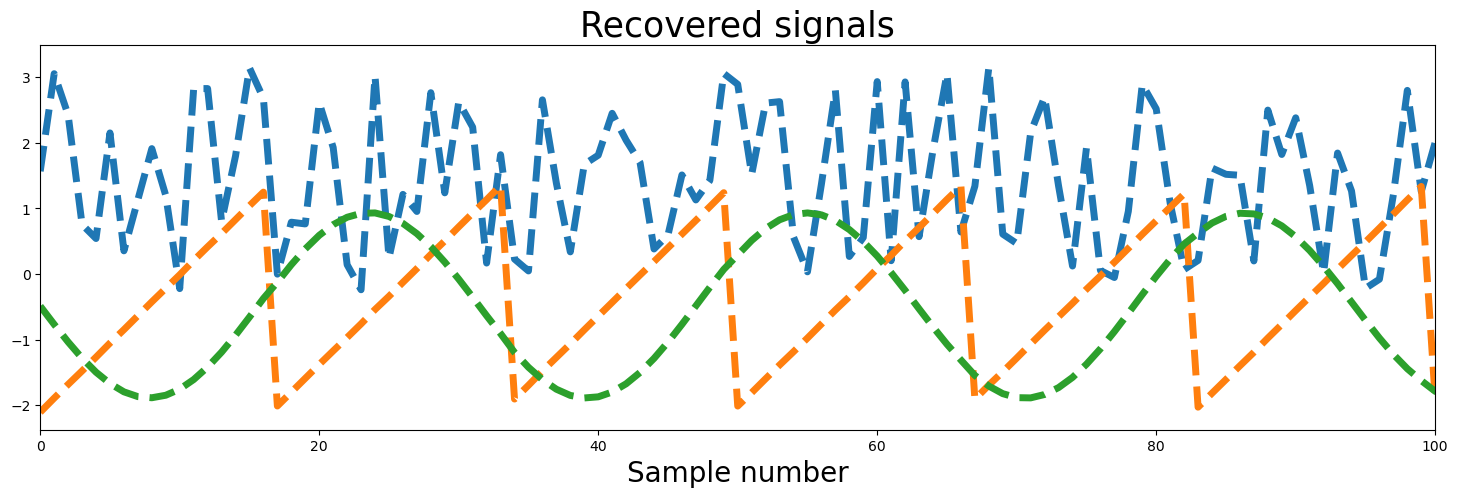

In [14]:
# Plot input signals (not mixed)
fig, ax = plt.subplots(1, 1, figsize=[18, 5])
ax.plot(S, lw=5)
ax.tick_params(labelsize=12)
ax.set_xticks([])
ax.set_yticks([-1, 1])
ax.set_title('Source signals', fontsize=25)
ax.set_xlim(0, 100)

fig, ax = plt.subplots(1, 1, figsize=[18, 5])
ax.plot(unMixed, '--', label='Recovered signals', lw=5)
ax.set_xlabel('Sample number', fontsize=20)
ax.set_title('Recovered signals', fontsize=25)
ax.set_xlim(0, 100)

plt.show()

The result of the ICA are plotted above, and the result looks very good. We got all three sources back!

## Kurtosis

So finally lets check one last thing: The kurtosis of the signals. 
Kurtosis is the fourth moment of the data and measures the "tailedness" of a distribution. A normal distribution has a value of 3, a uniform distribution like the one we used in our toy data has a kurtosis < 3. The implementation in Python is straight forward as can be seen from the code below which also calculates the other moments of the data. The first moment is the mean, the second is the variance, the third is the skewness and the fourth is the kurtosis. Here 3 is subtracted from the fourth moment so that a normal distribution has a kurtosis of 0.

In [15]:
# Calculate Kurtosis

def kurt(x):
    n = np.shape(x)[0]
    mean = np.sum((x**1)/n) # Calculate the mean
    var = np.sum((x-mean)**2)/n # Calculate the variance
    skew = np.sum((x-mean)**3)/n # Calculate the skewness
    kurt = np.sum((x-mean)**4)/n # Calculate the kurtosis
    kurt = kurt/(var**2)-3

    return kurt, skew, var, mean

As we can see in the following all of our mixed signals have a kurtosis of ≤ 1 whereas all recovered independent components have a kurtosis of 1.5 which means they are less Gaussian than their sources. This has to be the case since the ICA tries to maximize non-Gaussianity. Also it nicely illustrates the fact mentioned above that the mixture of non-Gaussian signals will be more Gaussian than the sources.

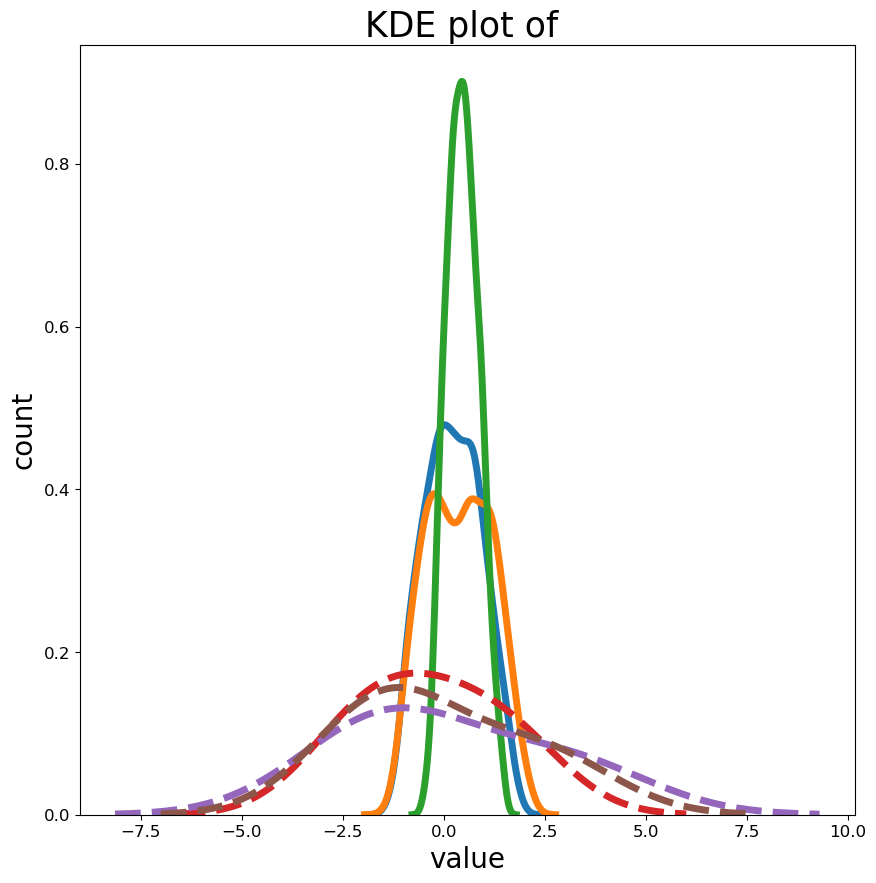

In [16]:
import seaborn as sns

fig, ax = plt.subplots(1, 1, figsize=(10,10))
for i in range(X.shape[0]):
    
    sns.kdeplot(X[i, :], lw=5, label='Mixed Kurtosis={}'.format(np.round(kurt(X[i, :])[0], decimals=1)))
    
for i in range(X.shape[0]):   
    sns.kdeplot(unMixed[i, :], lw=5, ls='--', label='unMixed Kurtosis={}'.format(np.around(kurt(unMixed[i, :])[0], decimals=1)))

ax.tick_params(labelsize=12)
ax.set_xlabel('value', fontsize=20)
ax.set_ylabel('count', fontsize=20)
ax.set_title('KDE plot of ', fontsize=25)
plt.show()